In [1]:
import os
import cv2
import time
import random
import numpy as np
import albumentations as augs
from matplotlib import pyplot as plt
from IPython.display import clear_output

from utils import *
from datasets import *


print('Ready')

Ready


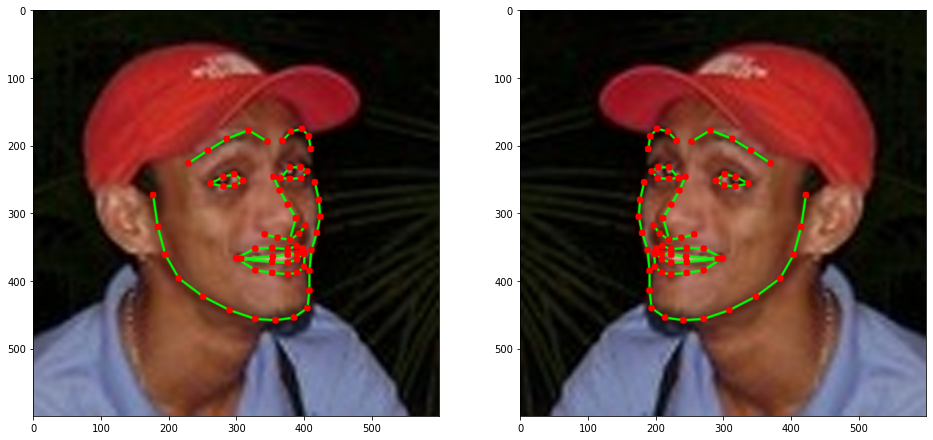

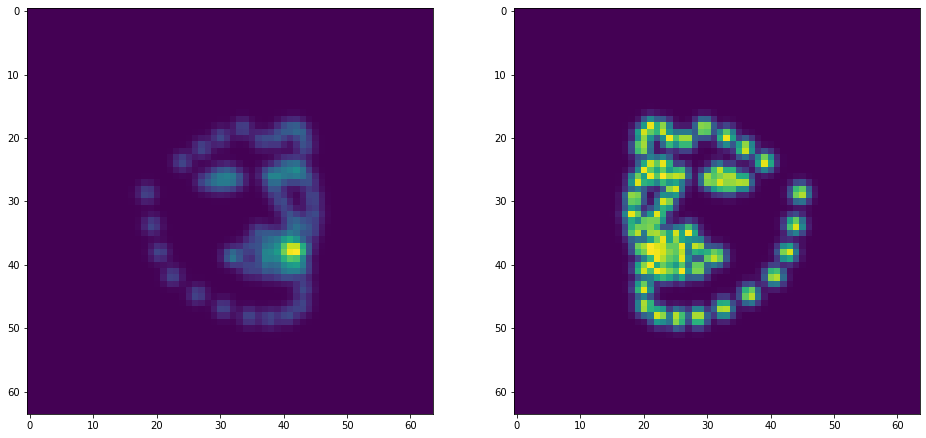

Average reconstruction error (MAE): 2.4310343801282805e-05


In [2]:
# Test pts utils
im_path = './data/300w/ibug/image_050.png'
pts_path = './data/300w/ibug/image_050.pts'
im = cv2.imread(im_path)
pts = load_pts(pts_path)
flipped_pts = flip_landmarks(pts, im.shape[1])
for idx in range(pts.shape[0]):
    clear_output(wait=True)
    fig = plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    im_disp = im.copy()
    if idx > 0:
        pts_disp = pts.copy()
        pts_disp[idx:] = pts_disp[idx]
        plot_landmarks(im_disp, pts_disp, connection_thickness=2, landmark_radius=5)
    plt.imshow(im_disp[..., ::-1])
    plt.subplot(1, 2, 2)
    im_disp = im[:, ::-1, :].copy()
    if idx > 0:
        pts_disp = flipped_pts.copy()
        pts_disp[idx:] = pts_disp[idx]
        plot_landmarks(im_disp, pts_disp, connection_thickness=2, landmark_radius=5)
    plt.imshow(im_disp[..., ::-1])
    plt.show()
    time.sleep(0.1)

heatmaps = encode_landmarks(pts / im.shape[1::-1] * 64, 64, 64, 5, 1)
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(heatmaps.sum(axis=0))
heatmaps = encode_landmarks(flipped_pts / im.shape[1::-1] * 64, 64, 64, 5, 1)
plt.subplot(1, 2, 2)
plt.imshow(heatmaps.max(axis=0)[0])
plt.show()
recon_err = np.abs(flipped_pts - decode_landmarks(heatmaps)[0] / 64 * im.shape[1::-1]).mean()
print(f"Average reconstruction error (MAE): {recon_err}")

In [3]:
# Test the dataset class
ibug_300w_lp_train = LandmarkDataset('data/300w_lp.tsv', LandmarkDataset.get_partitions('300w_lp', 'train'),
                                     random_flip=True)
ibug_300w_lp_train.geometric_transform = augs.ShiftScaleRotate(p=0.5, border_mode=cv2.BORDER_CONSTANT)
ibug_300w_lp_train.content_transform = augs.Compose([augs.Blur(p=0.5), augs.ColorJitter(p=0.5),
                                                     augs.ImageCompression(quality_lower=30, p=0.5)])
print(f"{len(ibug_300w_lp_train)} samples located.")

180689 samples located.


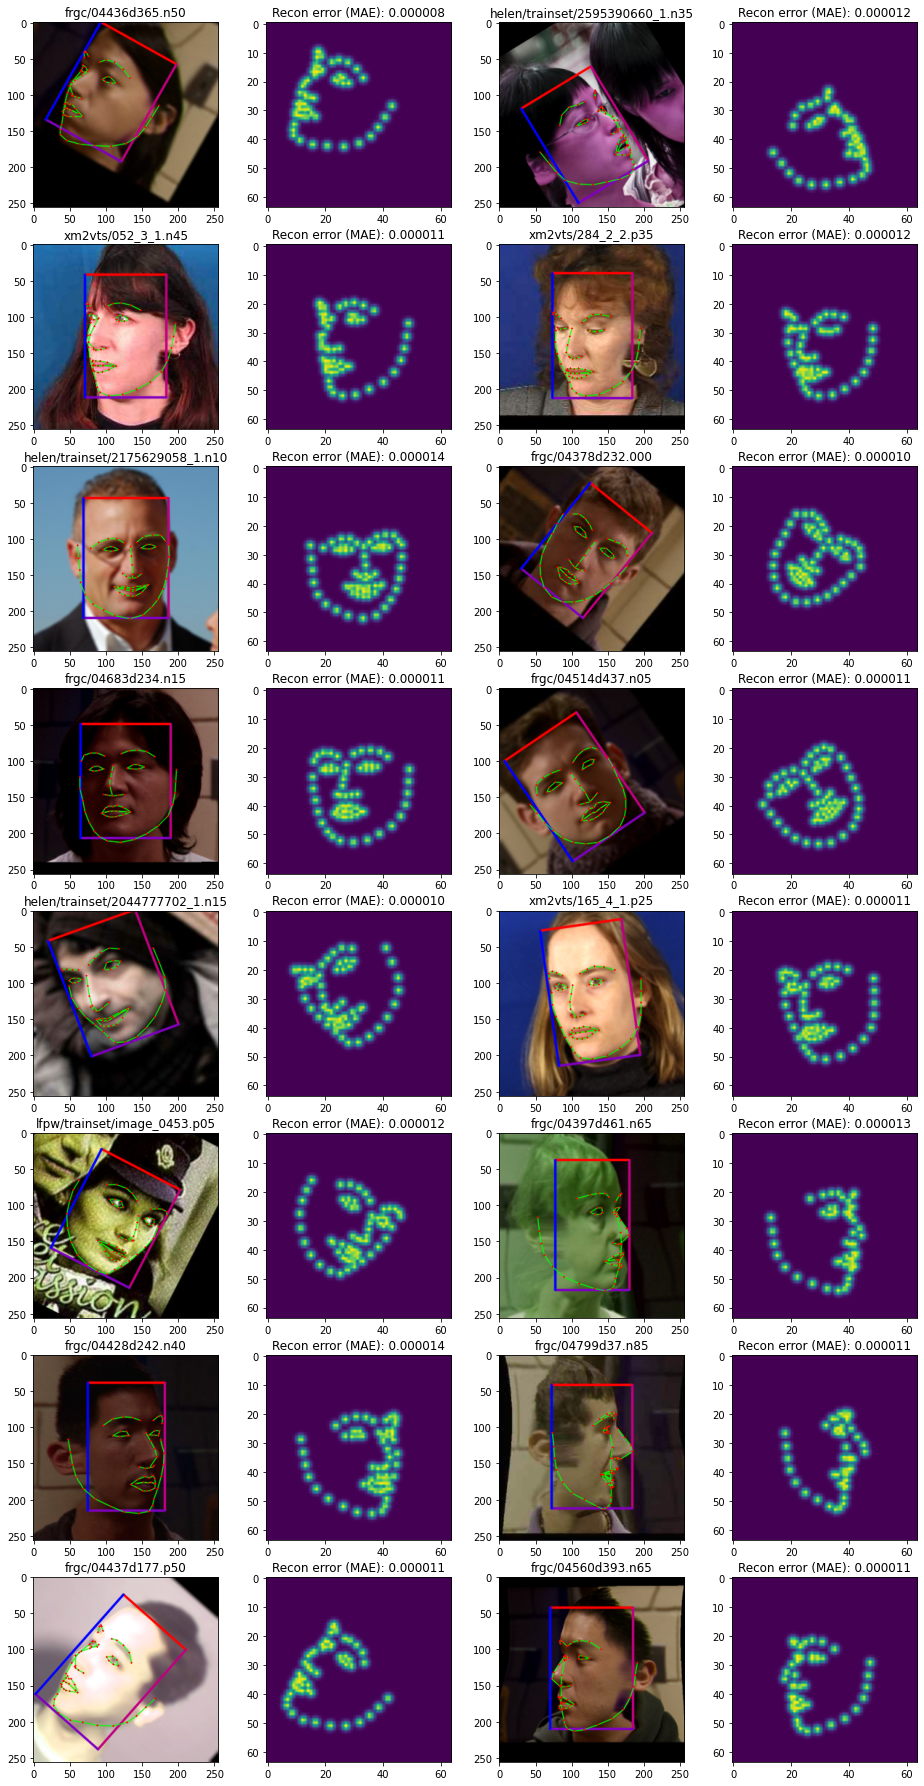

In [4]:
# Show some examples from the dataset
fig = plt.figure(figsize=(16, 32))
for idx in range(16):
    plt.subplot(8, 4, idx * 2 + 1)
    im, ht, pts, fcs, metadata = ibug_300w_lp_train[random.randint(0, len(ibug_300w_lp_train) - 1)]
    im = (im.numpy().transpose((1, 2, 0)) * 255.0).astype(np.uint8)
    cv2.line(im, tuple(fcs[0].astype(int).tolist()), tuple(fcs[1].astype(int).tolist()),
             color=(255, 0, 0), thickness=2, lineType=cv2.LINE_AA)
    cv2.line(im, tuple(fcs[1].astype(int).tolist()), tuple(fcs[2].astype(int).tolist()),
             color=(192, 0, 128), thickness=2, lineType=cv2.LINE_AA)
    cv2.line(im, tuple(fcs[2].astype(int).tolist()), tuple(fcs[3].astype(int).tolist()),
             color=(128, 0, 192), thickness=2, lineType=cv2.LINE_AA)
    cv2.line(im, tuple(fcs[3].astype(int).tolist()), tuple(fcs[0].astype(int).tolist()),
             color=(0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
    plot_landmarks(im, pts, landmark_colour=(255, 0, 0))
    plt.imshow(im)
    plt.title(os.path.join(metadata['subset'], metadata['split'],
                           os.path.splitext(os.path.basename(metadata['im_path']))[0]))
    plt.subplot(8, 4, idx * 2 + 2)
    plt.imshow(ht.max(axis=0)[0])
    recon_err = np.abs(pts - decode_landmarks(ht)[0] / 64 * im.shape[1::-1]).mean()
    plt.title(f"Recon error (MAE): {recon_err:.06f}")
plt.show()